In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-07 22:24:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Translacja raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Łączenie się z raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 298573 (292K) [text/plain]
Zapis do: `laptops.csv.1'

laptops.csv.1       100%[===================>] 291,58K  --.-KB/s     w 0,1s    

2024-10-07 22:24:53 (2,73 MB/s) - zapisano `laptops.csv.1' [298573/298573]



In [152]:
df = pd.read_csv('laptops.csv')

<Axes: xlabel='final_price', ylabel='Count'>

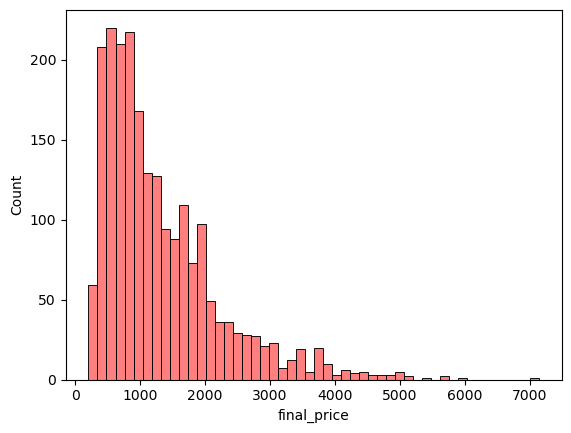

In [153]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
sns.histplot(df.final_price, bins=50, color='red', alpha=0.5)

In [224]:
# take only ram storage and price columns
df = df[['ram', 'storage', 'screen', 'final_price']]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


**Q. 1**

In [225]:
df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

**Q. 2**

In [226]:
df['ram'].median()

np.float64(16.0)

**Data preparation**

In [227]:
n = len(df)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

df = df.copy()
base = ['ram','storage','screen','final_price']

df = df[base]

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]
len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

df_train.head()

,ram,storage,screen
0,32,1000,15.6
1,4,64,14.1
2,32,1000,14.0
3,16,512,13.3
4,32,1000,16.0


**Q. 3**

In [230]:
df.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [231]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

# base = ['screen']


def prepare_X_zero(df):
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_mean(df):
    df_num = df
    df_num['screen'] = df_num['screen'].fillna(df_num['screen'].mean())
    X = df_num.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [234]:
X_train_zero = prepare_X_zero(df_train)
w0, w = train_linear_regression(X_train_zero, y_train)
y_pred = w0 + X_train_zero.dot(w)

w0, w

(np.float64(676.8954853016749),
 array([ 43.70681555,   0.86506867, -36.10399833]))

np.float64(602.3920520606714)

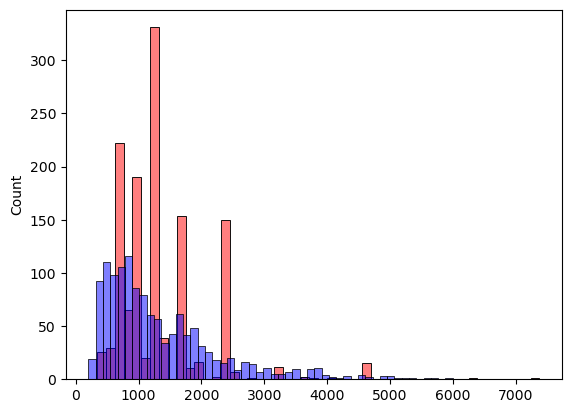

In [235]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
rmse(y_train, y_pred)

In [236]:
X_train_mean = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train_mean, y_train)

y_pred = w0 + X_train_mean.dot(w)

w0, w

(np.float64(808.9159907355192),
 array([ 43.90774584,   0.87135236, -45.18273312]))

np.float64(602.1844959403247)

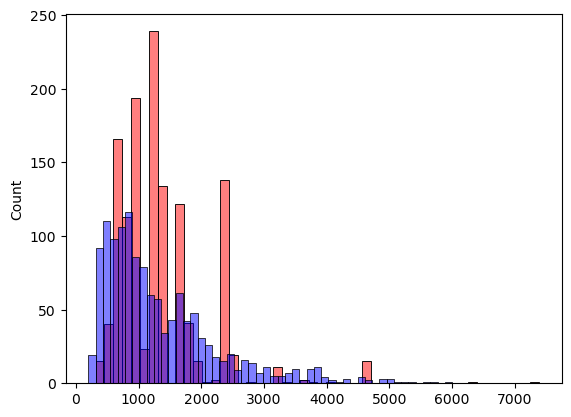

In [237]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
rmse(y_train, y_pred)

**Q. 4**

In [243]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])  
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]  

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.round(np.sqrt(mse), 2)

X_val = prepare_X_zero(df_val)

for r in [0, 0.01, 1,  10, 100]:
    w_0, w = train_linear_regression_reg(X_train_zero, y_train, r=r)
    y_pred_val_zeros = w_0 + X_val.dot(w)
    
    print(f"Regularization {r}: RMSE = {rmse(y_val, y_pred_val_zeros)} with bias {w_0} and weights {w}")

Regularization 0: RMSE = 597.36 with bias 676.8954853016749 and weights [ 43.70681555   0.86506867 -36.10399833]
Regularization 0.01: RMSE = 597.36 with bias 676.2736817217959 and weights [ 43.70642381   0.86504106 -36.06174277]
Regularization 1: RMSE = 597.21 with bias 619.9030834118271 and weights [ 43.67085331   0.8625399  -32.23099446]
Regularization 10: RMSE = 597.06 with bias 352.7971336771951 and weights [ 43.49940147   0.85075755 -14.07928221]
Regularization 100: RMSE = 597.9 with bias 66.92071440185458 and weights [43.26181083  0.83943545  5.35037812]


In [247]:
#  use different seed for shuffling



# standard deviation of RMSE
rmse_list = []

for a in range(10):
    idx = np.arange(n)
    np.random.seed(a)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]
    len(df_train), len(df_val), len(df_test)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # y_train = np.log1p(df_train.final_price.values)
    # y_val = np.log1p(df_val.final_price.values)
    # y_test = np.log1p(df_test.final_price.values)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train_zero = prepare_X_zero(df_train)
    X_val = prepare_X_zero(df_val)
    w0, w = train_linear_regression(X_train_zero, y_train)

    y_pred = w0 + X_val.dot(w)
    print(f"Seed {a}: RMSE = {rmse(y_val, y_pred)}")
    rmse_list.append(rmse(y_val, y_pred))

print(round(np.std(rmse_list), 3))

Seed 0: RMSE = 565.45
Seed 1: RMSE = 636.8
Seed 2: RMSE = 588.96
Seed 3: RMSE = 597.81
Seed 4: RMSE = 571.96
Seed 5: RMSE = 573.24
Seed 6: RMSE = 647.34
Seed 7: RMSE = 550.44
Seed 8: RMSE = 587.33
Seed 9: RMSE = 576.1
29.176


In [250]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
#  combine train and validation datasets


df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]
# len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# y_train = np.log1p(df_train.final_price.values)
# y_val = np.log1p(df_val.final_price.values)
# y_test = np.log1p(df_test.final_price.values)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

X_train_full_zero = prepare_X_zero(df_full_train)
X_test = prepare_X_zero(df_test)

w0, w = train_linear_regression_reg(X_train_full_zero, y_full_train, r=0.01)

y_pred = w0 + X_test.dot(w)

rmse(y_val, y_pred_val_zeros)

ValueError: shapes (432,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)